In [74]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split,RandomizedSearchCV
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix,classification_report
import warnings

In [4]:
# load in data with relative path
tree_df = pd.read_csv('2015_Street_Tree_Census_-_Tree_Data.csv')

In [5]:
# drop columns
tree_df = tree_df.drop(columns=[
    'borocode', 'x_sp', 'y_sp', 'state', 'nta_name', 'zip_city', 'address',
    'spc_latin', 'created_at', 'tree_id', 'block_id', 'user_type', 'bin',
    'bbl', 'council district', 'boro_ct', 'census tract', 'problems', 'status',
    'stump_diam', 'postcode', 'community board', 'cncldist', 'st_assem', 'st_senate', 
    'nta', 'spc_common'
])

# drop NA and dead tree values
tree_df = tree_df[tree_df['health'].notna()]
tree_df = tree_df.dropna(how='any')

#no need for scaling 
# Ordinal Encode
health = ['Poor', 'Fair', 'Good']
enc = OrdinalEncoder(categories=[health])
tree_df['health'] = enc.fit_transform(tree_df[['health']])

steward = ['None', '1or2', '3or4', '4orMore']
enc = OrdinalEncoder(categories=[steward])
tree_df['steward'] = enc.fit_transform(tree_df[['steward']])

sidewalk = ['NoDamage', 'Damage']
enc = OrdinalEncoder(categories=[sidewalk])
tree_df['sidewalk'] = enc.fit_transform(tree_df[['sidewalk']])

curbloc = ['OnCurb', 'OffsetFromCurb']
enc = OrdinalEncoder(categories=[curbloc])
tree_df['curb_loc'] = enc.fit_transform(tree_df[['curb_loc']])

yes_no = ['No', 'Yes']
enc = OrdinalEncoder(categories=[yes_no])

yes_no_features = [
    'brch_other', 'brch_shoe', 'brch_light', 'trnk_other', 'trnk_light',
    'trunk_wire', 'root_other', 'root_grate', 'root_stone'
]

for feat in yes_no_features:
    tree_df[feat] = enc.fit_transform(tree_df[[feat]])
    
# One Hot Encode
enc = OneHotEncoder()
guards = enc.fit_transform(tree_df[['guards']])
tree_df['guards_' + enc.categories_[0][:]] = guards.toarray()
tree_df = tree_df.drop(columns=['guards'])

guards = enc.fit_transform(tree_df[['borough']])
tree_df['borough_' + enc.categories_[0][:]] = guards.toarray()
tree_df = tree_df.drop(columns=['borough'])

In [6]:
# split to x and y sets
y = np.asarray(tree_df['health'])
x = tree_df.drop(columns=['health'])

In [7]:
# random sample (stratified) for dev, test, train and val
x_dev, x_test, y_dev, y_test = train_test_split(x, y, test_size=0.2, random_state=42, stratify = y)
x_train, x_val, y_train, y_val = train_test_split(x_dev, y_dev, test_size=0.2, random_state=42, stratify = y_dev)

In [67]:
# over-sampling of training data
ros = RandomOverSampler(random_state=42)
x_ros, y_ros = ros.fit_resample(x_train, y_train)

In [73]:
pd.DataFrame(y_ros).value_counts()

0.0    338463
1.0    338463
2.0    338463
dtype: int64

In [9]:
# under sampling of training data
rus = RandomUnderSampler(random_state=42)
x_rus, y_rus = rus.fit_resample(x_train, y_train)

In [10]:
# smote sampling of training data
smote = SMOTE(random_state=42)
x_smote, y_smote = smote.fit_resample(x_train, y_train)

## model: Decision tree

In [34]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix,classification_report
import warnings
warnings.filterwarnings('ignore')
# function to evaluate the model
# no need for scaling
def model_result(model, x_train, y_train, x_test, y_test):
    model.fit(x_train, y_train)
    y_train_predict = model.predict(x_train)
    y_test_predict = model.predict(x_test)  
    
    # # accuracy scores
    # acc_train = accuracy_score(y_train,y_train_predict)
    # acc_test = accuracy_score(y_test,y_test_predict)
    
    # # print training and testing accuracy
    # print("Accuracy of Training data: ", acc_train)
    # print("Accuracy of Testing data: ", acc_test)
    
    # # print train and test f1 score
    # f1_train = f1_score(y_train, y_train_predict , average='weighted')
    # f1_test = f1_score(y_test, y_test_predict , average='weighted')
    # print("weigted f1 of Training data: ", f1_train)
    # print("weigted f1 of Testing data: ", f1_test)

    # confusion_matrix
    cf = confusion_matrix(y_test, model.predict(x_test))
    sns.heatmap(cf, annot = True, fmt = 'g')
    plt.show()
    # result plot
    print(classification_report(y_test, y_test_predict))

## Modeling and hyperparameter tuning for different sampling

In [12]:
from sklearn.tree import DecisionTreeClassifier
from imblearn.under_sampling import RandomUnderSampler
# function to fit and tune the model
def dt_select(x_train,y_train,score):
    # possible values for the model to be tuned on
    param_grid = {
        'max_depth': [4,8,10,12,15,20],
        'min_samples_split': np.linspace(0.1, 0.3, 3, endpoint=True),
        "max_features":["log2","sqrt",None],
        "max_leaf_nodes": [None,10,20,30],
        'ccp_alpha' : np.logspace(-6, -4, 3)
    }
    
    # create a base model
    dt = DecisionTreeClassifier(random_state=100)

    # initantiate the random search model based on parameters defined above
    randomized_search = RandomizedSearchCV(estimator = dt, param_distributions = param_grid, scoring=score,cv=5)

    randomized_model=randomized_search.fit(x_train,y_train)
    return randomized_model

In [19]:
#plot feature importance
import matplotlib.pyplot as plt
import seaborn as sns
def feature_importance(x_train, model):
  features = x_train.columns.values
  plt.figure(figsize = (12, 6))
  ax = sns.barplot(x = features, y = model.best_estimator_.feature_importances_)
  ax.tick_params(axis = 'x', rotation = 90)

## random sample (stratified)

In [15]:
#accuracy as scoring metric
random_best = dt_select(x_train,y_train,'accuracy')
print("optimal hyperparameters",random_best.best_params_)
print("optimal accuracy score", random_best.best_score_)
print("test accuracy score",random_best.score(x_test,y_test))

optimal hyperparameters {'min_samples_split': 0.3, 'max_leaf_nodes': 10, 'max_features': 'sqrt', 'max_depth': 8, 'ccp_alpha': 1e-05}
optimal accuracy score 0.8109073571767318
test accuracy score 0.8109081987825261


Accuracy of Training data:  0.8109073571832444
Accuracy of Testing data:  0.8109081987825261
weigted f1 of Training data:  0.7262334423962195
weigted f1 of Testing data:  0.7262346123285616


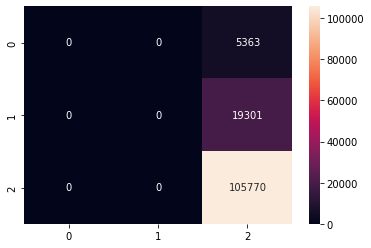

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00      5363
         1.0       0.00      0.00      0.00     19301
         2.0       0.81      1.00      0.90    105770

    accuracy                           0.81    130434
   macro avg       0.27      0.33      0.30    130434
weighted avg       0.66      0.81      0.73    130434



In [24]:
y_test_predict = random_best.predict(x_test)  
targets=['Poor', 'Fair', 'Good']
model_result(random_best, x_train, y_train, x_test, y_test)

In [27]:
#f1 as scoring metric
random_best = dt_select(x_train,y_train,'f1_weighted')
print("optimal hyperparameters",random_best.best_params_)
print("optimal f1 score", random_best.best_score_)
print("test f1 score",random_best.score(x_test,y_test))

optimal hyperparameters {'min_samples_split': 0.3, 'max_leaf_nodes': 10, 'max_features': 'log2', 'max_depth': 15, 'ccp_alpha': 0.0001}
optimal f1 score 0.7262334423875809
test f1 score 0.7262346123285616


Accuracy of Training data:  0.8109073571832444
Accuracy of Testing data:  0.8109081987825261
weigted f1 of Training data:  0.7262334423962195
weigted f1 of Testing data:  0.7262346123285616


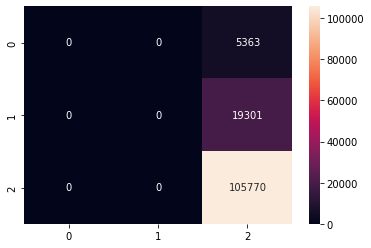

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00      5363
         1.0       0.00      0.00      0.00     19301
         2.0       0.81      1.00      0.90    105770

    accuracy                           0.81    130434
   macro avg       0.27      0.33      0.30    130434
weighted avg       0.66      0.81      0.73    130434



In [28]:
model_result(random_best, x_train, y_train, x_test, y_test)

optimal hyperparameters {'min_samples_split': 0.1, 'max_leaf_nodes': None, 'max_features': 'sqrt', 'max_depth': 8, 'ccp_alpha': 1e-06}
optimal f1 score 0.8109073571767318
test f1 score 0.8109081987825261
Accuracy of Training data:  0.8109073571832444
Accuracy of Testing data:  0.8109081987825261
weigted f1 of Training data:  0.7262334423962195
weigted f1 of Testing data:  0.7262346123285616


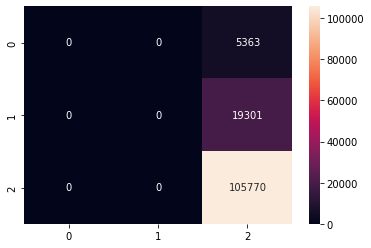

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00      5363
         1.0       0.00      0.00      0.00     19301
         2.0       0.81      1.00      0.90    105770

    accuracy                           0.81    130434
   macro avg       0.27      0.33      0.30    130434
weighted avg       0.66      0.81      0.73    130434



In [29]:
#recall weight as scoring metric
random_best = dt_select(x_train,y_train,'recall_weighted')
print("optimal hyperparameters",random_best.best_params_)
print("optimal f1 score", random_best.best_score_)
print("test f1 score",random_best.score(x_test,y_test))
model_result(random_best, x_train, y_train, x_test, y_test)

optimal hyperparameters {'min_samples_split': 0.1, 'max_leaf_nodes': 30, 'max_features': 'sqrt', 'max_depth': 10, 'ccp_alpha': 0.0001}
optimal score nan


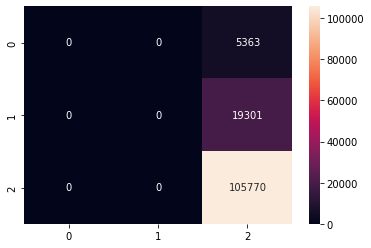

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00      5363
         1.0       0.00      0.00      0.00     19301
         2.0       0.81      1.00      0.90    105770

    accuracy                           0.81    130434
   macro avg       0.27      0.33      0.30    130434
weighted avg       0.66      0.81      0.73    130434



In [75]:
random_best = dt_select(x_train,y_train,'average_precision')
print("optimal hyperparameters",random_best.best_params_)
print("optimal score", random_best.best_score_)

model_result(random_best, x_train, y_train, x_test, y_test)

Accuracy of Training data:  0.8109073571832444
Accuracy of Testing data:  0.8109081987825261
weigted f1 of Training data:  0.7262334423962195
weigted f1 of Testing data:  0.7262346123285616


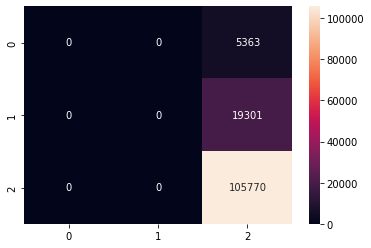

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00      5363
         1.0       0.00      0.00      0.00     19301
         2.0       0.81      1.00      0.90    105770

    accuracy                           0.81    130434
   macro avg       0.27      0.33      0.30    130434
weighted avg       0.66      0.81      0.73    130434



In [31]:
model_result(random_best, x_train, y_train, x_test, y_test)

hyperparamter the same for borh metircs

## oversampling

optimal hyperparameters {'min_samples_split': 0.2, 'max_leaf_nodes': 30, 'max_features': None, 'max_depth': 4, 'ccp_alpha': 1e-05}
optimal accuracy score 0.4108917864089053
test accuracy 0.6186117116702701
Accuracy of Training data:  0.4060138528189689
Accuracy of Testing data:  0.6246530812518208
weigted f1 of Training data:  0.32203780773959395
weigted f1 of Testing data:  0.6438258280190802


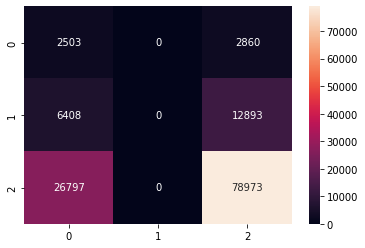

              precision    recall  f1-score   support

         0.0       0.07      0.47      0.12      5363
         1.0       0.00      0.00      0.00     19301
         2.0       0.83      0.75      0.79    105770

    accuracy                           0.62    130434
   macro avg       0.30      0.40      0.30    130434
weighted avg       0.68      0.62      0.64    130434



In [32]:
#accuracy as metric for hyperparamter pruning
over_best = dt_select(x_ros, y_ros,'accuracy')

print("optimal hyperparameters",over_best.best_params_)
print("optimal accuracy score", over_best.best_score_)
#y_pred=over_best.predict(x_test)
print("test accuracy",over_best.score(x_test,y_test))
model_result(over_best, x_ros, y_ros, x_test, y_test)

optimal hyperparameters {'min_samples_split': 0.1, 'max_leaf_nodes': None, 'max_features': None, 'max_depth': 8, 'ccp_alpha': 1e-06}
optimal accuracy score 0.39557413924226675
test accuracy 0.6258606258151398
Accuracy of Training data:  0.41505767740245364
Accuracy of Testing data:  0.4713571614763022
weigted f1 of Training data:  0.4079269747649852
weigted f1 of Testing data:  0.5513119503615664


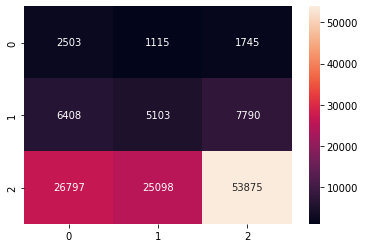

              precision    recall  f1-score   support

         0.0       0.07      0.47      0.12      5363
         1.0       0.16      0.26      0.20     19301
         2.0       0.85      0.51      0.64    105770

    accuracy                           0.47    130434
   macro avg       0.36      0.41      0.32    130434
weighted avg       0.72      0.47      0.55    130434



In [33]:
#f1_weighted as score
over_best = dt_select(x_ros, y_ros,'f1_weighted')

print("optimal hyperparameters",over_best.best_params_)
print("optimal accuracy score", over_best.best_score_)
#y_pred=over_best.predict(x_test)
print("test accuracy",over_best.score(x_test,y_test))
model_result(over_best, x_ros, y_ros, x_test, y_test)


optimal hyperparameters {'min_samples_split': 0.2, 'max_leaf_nodes': 30, 'max_features': None, 'max_depth': 4, 'ccp_alpha': 0.0001}
optimal accuracy score 0.42386508058489125
test accuracy 0.7197608397409707


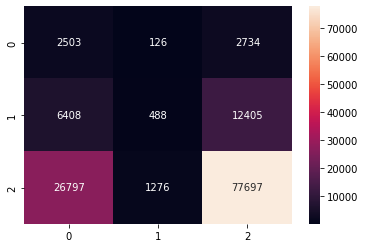

              precision    recall  f1-score   support

         0.0       0.07      0.47      0.12      5363
         1.0       0.26      0.03      0.05     19301
         2.0       0.84      0.73      0.78    105770

    accuracy                           0.62    130434
   macro avg       0.39      0.41      0.32    130434
weighted avg       0.72      0.62      0.65    130434



In [36]:
#precision_weighted as score
over_best = dt_select(x_ros, y_ros,'precision_weighted')

print("optimal hyperparameters",over_best.best_params_)
print("optimal accuracy score", over_best.best_score_)
#y_pred=over_best.predict(x_test)
print("test accuracy",over_best.score(x_test,y_test))
model_result(over_best, x_ros, y_ros, x_test, y_test)

optimal hyperparameters {'min_samples_split': 0.2, 'max_leaf_nodes': 20, 'max_features': None, 'max_depth': 8, 'ccp_alpha': 1e-05}
optimal accuracy score 0.4165339625898258
test accuracy 0.47135716147630224


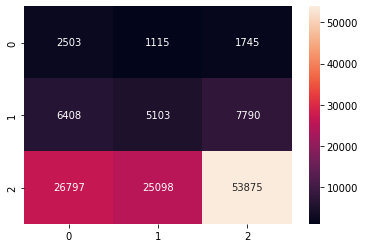

              precision    recall  f1-score   support

         0.0       0.07      0.47      0.12      5363
         1.0       0.16      0.26      0.20     19301
         2.0       0.85      0.51      0.64    105770

    accuracy                           0.47    130434
   macro avg       0.36      0.41      0.32    130434
weighted avg       0.72      0.47      0.55    130434



In [35]:
#recall weighted as score
over_best = dt_select(x_ros, y_ros,'recall_weighted')

print("optimal hyperparameters",over_best.best_params_)
print("optimal accuracy score", over_best.best_score_)
#y_pred=over_best.predict(x_test)
print("test accuracy",over_best.score(x_test,y_test))
model_result(over_best, x_ros, y_ros, x_test, y_test)

optimal hyperparameters {'min_samples_split': 0.3, 'max_leaf_nodes': None, 'max_features': None, 'max_depth': 15, 'ccp_alpha': 1e-06}
optimal accuracy score nan


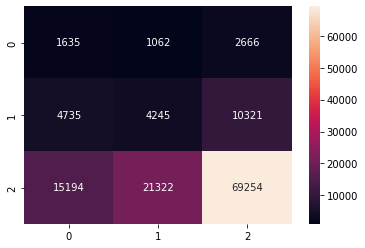

              precision    recall  f1-score   support

         0.0       0.08      0.30      0.12      5363
         1.0       0.16      0.22      0.18     19301
         2.0       0.84      0.65      0.74    105770

    accuracy                           0.58    130434
   macro avg       0.36      0.39      0.35    130434
weighted avg       0.71      0.58      0.63    130434



In [37]:
random_best = dt_select(x_train,y_train,'average_precision')
over_best = dt_select(x_ros, y_ros,'average_precision')

print("optimal hyperparameters",over_best.best_params_)
print("optimal accuracy score", over_best.best_score_)
#y_pred=over_best.predict(x_test)

model_result(over_best, x_ros, y_ros, x_test, y_test)

optimal hyperparameters {'min_samples_split': 0.2, 'max_leaf_nodes': None, 'max_features': None, 'max_depth': 12, 'ccp_alpha': 1e-06}
optimal score 0.41653391185405864
test score 0.41348892269960763


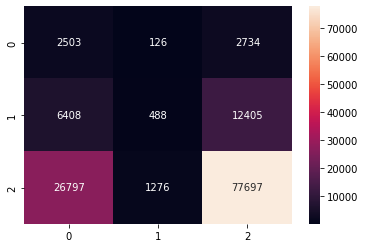

              precision    recall  f1-score   support

         0.0       0.07      0.47      0.12      5363
         1.0       0.26      0.03      0.05     19301
         2.0       0.84      0.73      0.78    105770

    accuracy                           0.62    130434
   macro avg       0.39      0.41      0.32    130434
weighted avg       0.72      0.62      0.65    130434



In [50]:
#recall macro as score
over_best = dt_select(x_ros, y_ros,'recall_macro')

print("optimal hyperparameters",over_best.best_params_)
print("optimal score", over_best.best_score_)
#y_pred=over_best.predict(x_test)
print("test score",over_best.score(x_test,y_test))
model_result(over_best, x_ros, y_ros, x_test, y_test)

precision best

## undersampling

optimal hyperparameters {'min_samples_split': 0.1, 'max_leaf_nodes': None, 'max_features': None, 'max_depth': 20, 'ccp_alpha': 1e-05}
optimal accuracy score 0.42282814886132025
test accuracy 0.5130334115338026


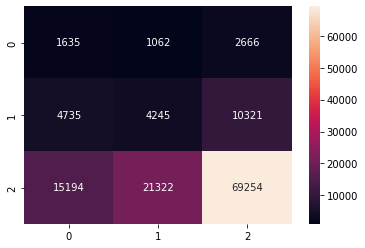

              precision    recall  f1-score   support

         0.0       0.08      0.30      0.12      5363
         1.0       0.16      0.22      0.18     19301
         2.0       0.84      0.65      0.74    105770

    accuracy                           0.58    130434
   macro avg       0.36      0.39      0.35    130434
weighted avg       0.71      0.58      0.63    130434



In [38]:
under_best = dt_select(x_rus, y_rus,'accuracy')
print("optimal hyperparameters",under_best.best_params_)
print("optimal accuracy score", under_best.best_score_)

print("test accuracy",under_best.score(x_test,y_test))
model_result(under_best, x_ros, y_ros, x_test, y_test)

optimal hyperparameters {'min_samples_split': 0.2, 'max_leaf_nodes': 10, 'max_features': None, 'max_depth': 12, 'ccp_alpha': 1e-05}
optimal accuracy score 0.403503916707413
test accuracy 0.5239295859951179


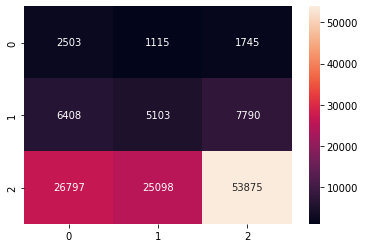

              precision    recall  f1-score   support

         0.0       0.07      0.47      0.12      5363
         1.0       0.16      0.26      0.20     19301
         2.0       0.85      0.51      0.64    105770

    accuracy                           0.47    130434
   macro avg       0.36      0.41      0.32    130434
weighted avg       0.72      0.47      0.55    130434



In [39]:
under_best = dt_select(x_rus, y_rus,'f1_weighted')
print("optimal hyperparameters",under_best.best_params_)
print("optimal accuracy score", under_best.best_score_)

print("test accuracy",under_best.score(x_test,y_test))
model_result(under_best, x_ros, y_ros, x_test, y_test)

optimal hyperparameters {'min_samples_split': 0.2, 'max_leaf_nodes': 30, 'max_features': None, 'max_depth': 12, 'ccp_alpha': 0.0001}
optimal accuracy score 0.41331703739340175
test accuracy 0.7134674141375095


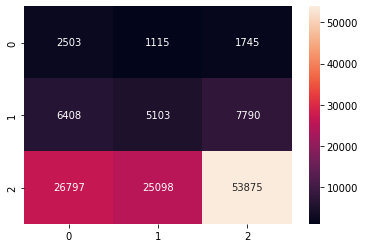

              precision    recall  f1-score   support

         0.0       0.07      0.47      0.12      5363
         1.0       0.16      0.26      0.20     19301
         2.0       0.85      0.51      0.64    105770

    accuracy                           0.47    130434
   macro avg       0.36      0.41      0.32    130434
weighted avg       0.72      0.47      0.55    130434



In [40]:
under_best = dt_select(x_rus, y_rus,'precision_weighted')
print("optimal hyperparameters",under_best.best_params_)
print("optimal accuracy score", under_best.best_score_)

print("test accuracy",under_best.score(x_test,y_test))
model_result(under_best, x_ros, y_ros, x_test, y_test)

optimal hyperparameters {'min_samples_split': 0.3, 'max_leaf_nodes': None, 'max_features': None, 'max_depth': 4, 'ccp_alpha': 1e-05}
optimal accuracy score 0.4043968914462073
test accuracy 0.6246530812518208


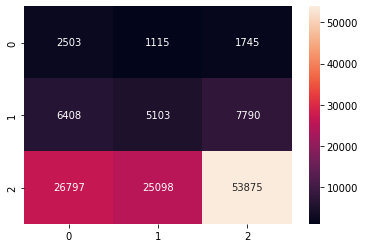

              precision    recall  f1-score   support

         0.0       0.07      0.47      0.12      5363
         1.0       0.16      0.26      0.20     19301
         2.0       0.85      0.51      0.64    105770

    accuracy                           0.47    130434
   macro avg       0.36      0.41      0.32    130434
weighted avg       0.72      0.47      0.55    130434



In [41]:
under_best = dt_select(x_rus, y_rus,'recall_weighted')
print("optimal hyperparameters",under_best.best_params_)
print("optimal accuracy score", under_best.best_score_)

print("test accuracy",under_best.score(x_test,y_test))
model_result(under_best, x_ros, y_ros, x_test, y_test)

optimal hyperparameters {'min_samples_split': 0.1, 'max_leaf_nodes': 20, 'max_features': None, 'max_depth': 10, 'ccp_alpha': 1e-06}
optimal accuracy score 0.4226153511181184
test accuracy 0.4202120521676436


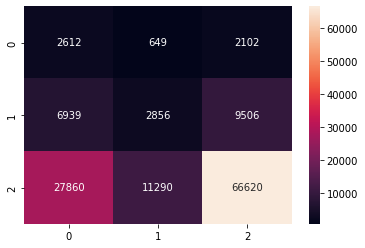

              precision    recall  f1-score   support

         0.0       0.07      0.49      0.12      5363
         1.0       0.19      0.15      0.17     19301
         2.0       0.85      0.63      0.72    105770

    accuracy                           0.55    130434
   macro avg       0.37      0.42      0.34    130434
weighted avg       0.72      0.55      0.62    130434



In [49]:
under_best = dt_select(x_rus, y_rus,'recall_macro')
print("optimal hyperparameters",under_best.best_params_)
print("optimal score", under_best.best_score_)

print("test score",under_best.score(x_test,y_test))
model_result(under_best, x_ros, y_ros, x_test, y_test)

In [53]:
# from sklearn.metrics import brier_score_loss
# from sklearn.calibration import CalibrationDisplay, CalibratedClassifierCV
# # Isotonic Regression
# cal_isotonic = CalibratedClassifierCV(under_best, cv = "prefit", method = "isotonic")
# cal_isotonic.fit(x_rus, y_rus)
# display_isotonic = CalibrationDisplay.from_estimator(cal_isotonic, x_test, y_test, n_bins = 10, name = 'Calibrated (Isotonic)')

# # Platt Scaling
# cal_platt = CalibratedClassifierCV(under_best, cv = "prefit", method = "sigmoid")
# cal_platt.fit(x_rus, y_rus)
# display_platt = CalibrationDisplay.from_estimator(cal_platt, x_test, y_test, n_bins = 10, name = 'Calibrated (Platt)')

except accuracy, no difference

## SMOTE

optimal hyperparameters {'min_samples_split': 0.1, 'max_leaf_nodes': 10, 'max_features': None, 'max_depth': 20, 'ccp_alpha': 1e-06}
optimal accuracy score 0.4135922296163505
test accuracy 0.6186117116702701


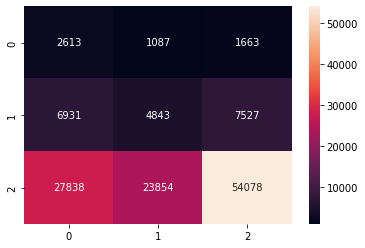

              precision    recall  f1-score   support

         0.0       0.07      0.49      0.12      5363
         1.0       0.16      0.25      0.20     19301
         2.0       0.85      0.51      0.64    105770

    accuracy                           0.47    130434
   macro avg       0.36      0.42      0.32    130434
weighted avg       0.72      0.47      0.55    130434



In [43]:
#accuracy as metric
smote_best = dt_select(x_smote, y_smote,"accuracy")
print("optimal hyperparameters",smote_best.best_params_)
print("optimal accuracy score", smote_best.best_score_)
print("test accuracy",smote_best.score(x_test,y_test))
model_result(smote_best, x_smote, y_smote, x_test, y_test)

optimal hyperparameters {'min_samples_split': 0.1, 'max_leaf_nodes': 20, 'max_features': None, 'max_depth': 10, 'ccp_alpha': 1e-06}
optimal accuracy score 0.42223916356984786
test accuracy 0.4855329131974792


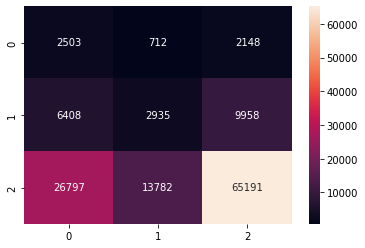

              precision    recall  f1-score   support

         0.0       0.07      0.47      0.12      5363
         1.0       0.17      0.15      0.16     19301
         2.0       0.84      0.62      0.71    105770

    accuracy                           0.54    130434
   macro avg       0.36      0.41      0.33    130434
weighted avg       0.71      0.54      0.61    130434



In [44]:
smote_best = dt_select(x_smote, y_smote,"recall_weighted")
print("optimal hyperparameters",smote_best.best_params_)
print("optimal accuracy score", smote_best.best_score_)
print("test accuracy",smote_best.score(x_test,y_test))
model_result(smote_best, x_smote, y_smote, x_test, y_test)

optimal hyperparameters {'min_samples_split': 0.1, 'max_leaf_nodes': 20, 'max_features': None, 'max_depth': 8, 'ccp_alpha': 1e-06}
optimal accuracy score 0.41117137282606286
test accuracy 0.5887237551093703


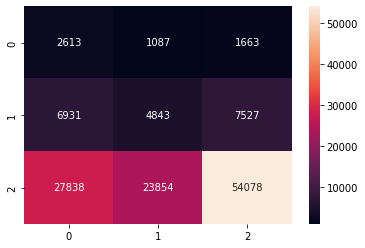

              precision    recall  f1-score   support

         0.0       0.07      0.49      0.12      5363
         1.0       0.16      0.25      0.20     19301
         2.0       0.85      0.51      0.64    105770

    accuracy                           0.47    130434
   macro avg       0.36      0.42      0.32    130434
weighted avg       0.72      0.47      0.55    130434



In [45]:
smote_best = dt_select(x_smote, y_smote,"f1_weighted")
print("optimal hyperparameters",smote_best.best_params_)
print("optimal accuracy score", smote_best.best_score_)
print("test accuracy",smote_best.score(x_test,y_test))
model_result(smote_best, x_smote, y_smote, x_test, y_test)

optimal hyperparameters {'min_samples_split': 0.1, 'max_leaf_nodes': 10, 'max_features': None, 'max_depth': 20, 'ccp_alpha': 0.0001}
optimal accuracy score 0.4275407152492544
test accuracy 0.7197608397409707


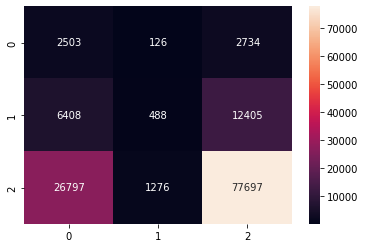

              precision    recall  f1-score   support

         0.0       0.07      0.47      0.12      5363
         1.0       0.26      0.03      0.05     19301
         2.0       0.84      0.73      0.78    105770

    accuracy                           0.62    130434
   macro avg       0.39      0.41      0.32    130434
weighted avg       0.72      0.62      0.65    130434



In [46]:
smote_best = dt_select(x_smote, y_smote,"precision_weighted")
print("optimal hyperparameters",smote_best.best_params_)
print("optimal accuracy score", smote_best.best_score_)
print("test accuracy",smote_best.score(x_test,y_test))
model_result(smote_best, x_smote, y_smote, x_test, y_test)

optimal hyperparameters {'min_samples_split': 0.2, 'max_leaf_nodes': 20, 'max_features': None, 'max_depth': 10, 'ccp_alpha': 0.0001}
optimal score 0.418894632394582
test score 0.4117092800491748


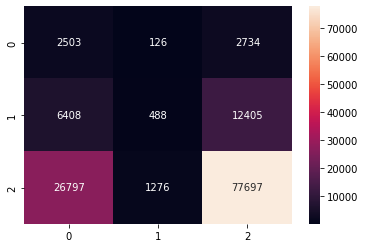

              precision    recall  f1-score   support

         0.0       0.07      0.47      0.12      5363
         1.0       0.26      0.03      0.05     19301
         2.0       0.84      0.73      0.78    105770

    accuracy                           0.62    130434
   macro avg       0.39      0.41      0.32    130434
weighted avg       0.72      0.62      0.65    130434



In [51]:
smote_best = dt_select(x_smote, y_smote,"recall_macro")
print("optimal hyperparameters",smote_best.best_params_)
print("optimal score", smote_best.best_score_)
print("test score",smote_best.score(x_test,y_test))
model_result(smote_best, x_smote, y_smote, x_test, y_test)

In [66]:
y_ros.values()

AttributeError: ignored